In [48]:
import lmdb
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import torch
import torchvision.transforms as T
import os
from data import BedsoreDataset
import torchvision

In [4]:
image_list = Path('data/VOCdevkit/VOC2007/JPEGImages/').rglob('*.jpg')
image_list = list(image_list)

In [2]:
# creat lmdb dataset

env = lmdb.open('JPEGImages_db',map_size=int(1e10))
for i in tqdm(image_list):
    name = i.name[:-4]
    with open(i, 'rb') as f:
        image_bin = f.read()
    with env.begin(write=True) as txn:
        txn.put(name.encode(), image_bin)
env.close()

100%|██████████| 1528/1528 [00:04<00:00, 344.81it/s]


In [9]:
# save arr to  lmdb dataset

env = lmdb.open('Byte_db',map_size=int(1e11))
for i in tqdm(image_list):
    name = i.name[:-4]
    arr = cv2.imread(str(i))
    arr = arr.tobytes()
    with env.begin(write=True) as txn:
        txn.put(name.encode(), arr)
env.close()

100%|██████████| 1528/1528 [02:03<00:00, 12.32it/s]


In [6]:
%%time
for i in tqdm(image_list):
    image = Image.open(i)
    arr = np.array(image)

100%|██████████| 1528/1528 [01:22<00:00, 18.63it/s]

CPU times: user 1min 12s, sys: 9.31 s, total: 1min 22s
Wall time: 1min 22s


In [8]:
## read lmdb
%%time
env = lmdb.open('JPEGImages_db')
with env.begin(write=False, buffers=True) as txn:
    for key, value in tqdm(txn.cursor()):
        name = key
        image_bin = value
        image_buf = np.frombuffer(image_bin, dtype=np.uint8)
        img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)
#         img = torch.from_numpy(img)
env.close()

1528it [01:04, 23.66it/s]

CPU times: user 1min 1s, sys: 3.76 s, total: 1min 4s
Wall time: 1min 4s


In [2]:

## read lmdb

env = lmdb.open('Byte_db')
with env.begin(write=False,buffers=True) as txn:
    for key, value in tqdm(txn.cursor()):
        name = key
        image_bin = value
        image_buf = np.frombuffer(image_bin, dtype=np.uint8)
env.close()

0it [00:00, ?it/s]


In [26]:
# load arr form lmdb
env = lmdb.open('JPEGImages')
with env.begin(write=False) as txn:
    image_bin = txn.get('0'.encode())
    image_buf = np.frombuffer(image_bin, dtype=np.uint8)
    img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)

/home/zrway/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/home/zrway/anaconda3/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumP

In [8]:
ds = torchvision.datasets.VOCDetection('data',year='2007',image_set='trainval')

In [ ]:
# make byte_db
env = lmdb.open('Byte_db',map_size=int(3e10))
with env.begin(write=True) as txn:
    for i,d in enumerate(tqdm(ds)):
        fname = d[1]['annotation']['filename'][:-4]
        mask_class_path = f'data/VOCdevkit/VOC2007/SegmentationClass/{fname}.png'
        mask_object_path = f'data/VOCdevkit/VOC2007/SegmentationObject/{fname}.png'
        if os.path.exists(mask_class_path):
            mask = Image.open(mask_object_path).convert('L')
            mask_class = Image.open(mask_class_path).convert('L')
            mask_byte = np.array(mask).tobytes()
            mask_class_byte = np.array(mask_class).tobytes()
            arr = np.array(d[0])
            byte = arr.tobytes()
            anno = str(d[1])
            txn.put(f'data_{i}'.encode(), byte)
            txn.put(f'anno_{i}'.encode(), anno.encode())
            txn.put(f'mask_{i}'.encode(), mask_byte)
            txn.put(f'mask_class_{i}'.encode(), mask_class_byte)
        else:
            print(fname,'not exist')
env.close()

In [27]:
id = 3
env = lmdb.open('data/arr_lmdb')
with env.begin(write=False) as txn:
    arr = txn.get(f'data_{id}'.encode())
    anno = txn.get(f'anno_{id}'.encode())
    anno = eval(anno)
    w = anno['annotation']['size']['width']
    h = anno['annotation']['size']['height']
    arr = np.frombuffer(arr, dtype=np.uint8)
    arr = arr.reshape(int(h),int(w),3)
    
    mask = txn.get(f'mask_{id}'.encode())
    if mask is not None:
        mask = np.frombuffer(mask, dtype=np.uint8)
        mask = mask.reshape(int(h),int(w))

        mask_class = txn.get(f'mask_class_{id}'.encode())
        mask_class = np.frombuffer(mask_class, dtype=np.uint8)
        mask_class = mask_class.reshape(int(h),int(w))

env.close()

TypeError: eval() arg 1 must be a string, bytes or code object

In [26]:
np.unique(mask_class)

array([  0, 137, 173], dtype=uint8)

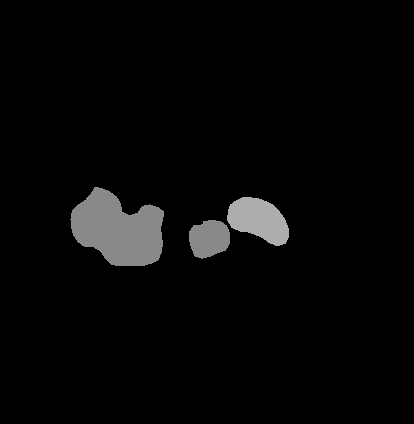

In [20]:
Image.fromarray(mask_class)

In [80]:
import copy
import os
import pathlib

import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
import albumentations as album
from albumentations.pytorch import ToTensorV2, ToTensor

In [74]:
class BedsoreDataset_lmdb(object):
    def __init__(self, root='data', transforms=None, image_set='train'):
        self.root = root
        self.transforms = transforms
        self.data = torchvision.datasets.VOCDetection(root,
                                                      year='2007',
                                                      image_set=image_set)
        self.label_dict = {
            '1期': 1,
            '2期': 2,
            '3期': 3,
            '4期': 4,
            '不可分期': 5,
            '深部组织损伤': 6
        }
        env = lmdb.open('data/arr_lmdb')
        self.txn = env.begin(write=False)
        
        

    def __getitem__(self, idx):
#         image = self.data[idx][0]#PIL
        
            anno = self.txn.get(f'anno_{idx}'.encode()) # sub self.data[idx][1]
            anno = eval(anno)
            w = anno['annotation']['size']['width']
            h = anno['annotation']['size']['height']

            image = self.txn.get(f'data_{idx}'.encode()) 
            image = np.frombuffer(image, dtype=np.uint8)#arr
            image = image.reshape(int(h),int(w),3)

            boxes, labels = [], []
            image_id = torch.tensor([idx])

            fname = anno['annotation']['filename'][:-4]

            mask = self.txn.get(f'mask_{idx}'.encode())
            if mask is not None:
                mask = np.frombuffer(mask, dtype=np.uint8)
                mask = mask.reshape(int(h),int(w))
                obj_ids = np.unique(mask)[1:]
                masks = mask == obj_ids[:, None, None]
                mask_class = self.txn.get(f'mask_class_{idx}'.encode())
                mask_class = np.frombuffer(mask_class, dtype=np.uint8)
                mask_class = mask_class.reshape(int(h),int(w))
                mask_class = masks * mask_class
                mask_label = mask_class.max(1).max(1).tolist()
                ccc = {
                    137: 7,
                    173: 8,
                    98: 9
                }  # 137-7:Necrotic,173-8:slough,98-9:Granulation
                mask_label = [ccc[i] if i in ccc else i for i in mask_label]
                num_objs = len(obj_ids)
                mask_boxes = []
                for i in range(num_objs):
                    pos = np.where(masks[i])
                    xmin = float(np.min(pos[1]))
                    xmax = float(np.max(pos[1]))
                    ymin = float(np.min(pos[0]))
                    ymax = float(np.max(pos[0]))
                    mask_boxes.append([xmin, ymin, xmax, ymax])
            else:
                masks = None
                mask_boxes = []
                mask_label = []

            if isinstance(anno['annotation']['object'], list):
                for i in anno['annotation']['object']:
                    bbox = list(i['bndbox'].values())
                    bbox = list(map(float, bbox))
                    boxes.append(bbox)
                    labels.append(self.label_dict[i['name']])
            else:
                bbox = list(
                    anno['annotation']['object']['bndbox'].values())
                bbox = list(map(float, bbox))
                boxes.append(bbox)
                labels.append(self.label_dict[anno['annotation']
                                              ['object']['name']])

            pre_masks = torch.zeros(len(labels), image.shape[0], image.shape[1])
            labels = labels + mask_label
            target = {}
            boxes = boxes + mask_boxes
            target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
            target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
            target['image_id'] = torch.as_tensor(image_id, dtype=torch.int64)
            target['fname'] = fname

            if masks is not None:
                masks = torch.from_numpy(masks)
                masks = torch.cat((pre_masks, masks), dim=0)
                target['masks'] = masks
            else:
                target['masks'] = pre_masks

            if self.transforms is not None:
                transformed = self.transforms(image=image,
                                              bboxes=target['boxes'],
                                              mask=target['masks'].permute(
                                                  1, 2, 0).numpy(),
                                              category_ids=target['labels'])
                image = transformed['image']
                target['boxes'] = torch.as_tensor(transformed['bboxes'],
                                                  dtype=torch.float32)
                target['masks'] = transformed['mask'][0].permute(2, 0, 1)

            return image, target

    def __len__(self):
        return len(self.data)

In [92]:
trans_prob=0.5
tfmc_train = album.Compose(
            [
                #  album.RandomScale(p=trans_prob, scale_limit=0.5),
                #  album.RandomShadow(p=trans_prob),
                album.RandomSizedBBoxSafeCrop(
                    800, 800, p=0.5, erosion_rate=0.2),
                album.HorizontalFlip(p=trans_prob),
                album.VerticalFlip(p=trans_prob),
                album.ShiftScaleRotate(p=trans_prob, rotate_limit=90),
                album.RandomBrightnessContrast(p=trans_prob),
                #  album.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
                ToTensor()
            ],
            bbox_params=album.BboxParams(format='pascal_voc',
                                         label_fields=['category_ids']))
ds = BedsoreDataset_lmdb(transforms=tfmc_train, image_set='train')

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


In [93]:
from torch.utils.data import DataLoader
import utils
dl = DataLoader(ds,batch_size=8,num_workers=8, collate_fn=utils.collate_fn)

In [94]:
%%time
for i in tqdm(dl):
    pass

 32%|███▏      | 53/168 [00:19<00:41,  2.76it/s]


ValueError: Caught ValueError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-74-bc4e10ec2486>", line 104, in __getitem__
    category_ids=target['labels'])
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/core/composition.py", line 180, in __call__
    p.preprocess(data)
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/core/utils.py", line 62, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/core/utils.py", line 70, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 51, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 251, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 330, in check_bbox
    "to be in the range [0.0, 1.0], got {value}.".format(bbox=bbox, name=name, value=value)
ValueError: Expected y_max for bbox (tensor(0.2071), tensor(0.3578), tensor(0.6276), tensor(1.1563), tensor(4)) to be in the range [0.0, 1.0], got 1.1563303470611572.


In [89]:
from data import BedsoreDataset,BedsoreDataModule
ds = BedsoreDataset(transforms=tfmc_train,image_set='train')
dl = DataLoader(ds,batch_size=8,num_workers=8, collate_fn=utils.collate_fn)

In [91]:
%%time
for i in tqdm(dl):
    pass

100%|██████████| 168/168 [01:31<00:00,  1.84it/s]

CPU times: user 2.6 s, sys: 5.66 s, total: 8.26 s
Wall time: 1min 31s
